<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 1.1 by Paulo Martins and Vitória Barbosa

## Importing Main Libraries

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# Preprocess data: standardization and normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

In [2]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/Steel_industry_data_task01.csv'

# Creating pandas dataframe from each dataset
df = pd.read_csv(dataset_url, names=['date', 'Usage_kWh',	'Lagging_Current_Reactive.Power_kVarh',	'Leading_Current_Reactive_Power_kVarh',	'CO2(tCO2)',	'Lagging_Current_Power_Factor',	'Leading_Current_Power_Factor',	'NSM',	'WeekStatus',	'Day_of_week',	'Load_Type',	'id'], skiprows=1, delimiter=',')


In [3]:
# Just checking that the dataframe was loaded correctly from the Github URL
print(df.head(5).to_markdown())

|    | date             |   Usage_kWh |   Lagging_Current_Reactive.Power_kVarh |   Leading_Current_Reactive_Power_kVarh |   CO2(tCO2) |   Lagging_Current_Power_Factor |   Leading_Current_Power_Factor |   NSM | WeekStatus   | Day_of_week   | Load_Type   |   id |
|---:|:-----------------|------------:|---------------------------------------:|---------------------------------------:|------------:|-------------------------------:|-------------------------------:|------:|:-------------|:--------------|:------------|-----:|
|  0 | 01/01/2018 00:15 |    -1571.8  |                                   2.95 |                                      0 |           0 |                          73.21 |                            100 |   nan | Weekday      | Monday        | Light_Load  | 6819 |
|  1 | 01/01/2018 00:30 |        4    |                                   4.46 |                                    nan |           0 |                          66.77 |                            100 |  1800 | Week

In [4]:
# Finally checking the data type of each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  31429 non-null  object 
 1   Usage_kWh                             31641 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  31514 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  31559 non-null  float64
 4   CO2(tCO2)                             31421 non-null  float64
 5   Lagging_Current_Power_Factor          31553 non-null  float64
 6   Leading_Current_Power_Factor          31488 non-null  float64
 7   NSM                                   31556 non-null  float64
 8   WeekStatus                            31586 non-null  object 
 9   Day_of_week                           31422 non-null  object 
 10  Load_Type                             31419 non-null  object 
 11  id             

## Data Cleansing

### Missing values

Total of rows 35040


<Axes: >

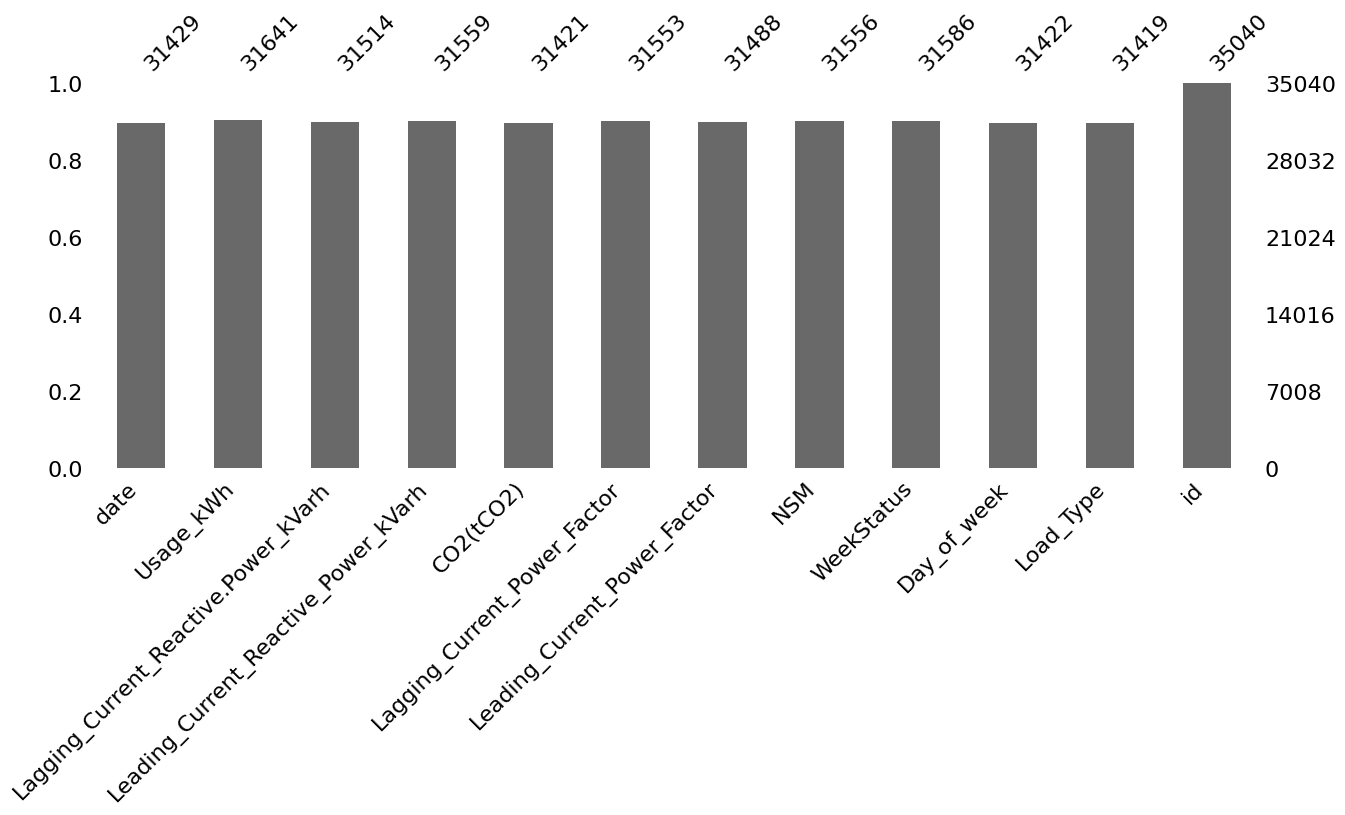

In [5]:
# Visualizing how many missing values there are
print(f"Total of rows {df.shape[0]}")
ms.bar(df, figsize=(15,5))

As you can see above, the total number of rows is 35040 (index) and the only column that is completely filled is the id column. Therefore we need to apply some techniques to replace missing values.

First, let's sort the data table based on the two most plausible columns: id and date. Based on the first 5 lines above, you can see that the id column has random values (also mentioned by the professor) and, obviously, we should avoid it. The only alternative for sorting the data is the date column.

In [6]:
# Sort the data based on date column
df = df.sort_values(by='date').reset_index(drop=True)

# Checking if the result makes sense
print(df.date.head(5).to_markdown())

|    | date             |
|---:|:-----------------|
|  0 | 01/01/2018 00:00 |
|  1 | 01/01/2018 00:15 |
|  2 | 01/01/2018 00:30 |
|  3 | 01/01/2018 00:45 |
|  4 | 01/01/2018 01:00 |


Before filling in the missing values column by column, let's check if there are any duplicate rows

In [7]:
# Looking for duplicate rows
grouped_df = df.groupby(list(df.columns)).size().reset_index(name='count_occurrences')
print(f"The maximum number of occurrences of row: {grouped_df.count_occurrences.max()}")
grouped_df = None

The maximum number of occurrences of row: 1


#### Date Column

Now it's time to analyze column by column, starting with the date. We can easily see that the cadence of the date column is 15 minutes. So, to fill in the missing values, we will check the value of the previous column and the next column to decide on the new value

In [8]:
# REVIEW THIS TOPIC - IT IS WRONG

# Change the column type to be able to apply some arithmetic to this column
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y %H:%M", errors='coerce')

# Fill missing values based on the previous filled value
while df['date'].isnull().any():
    df['date'].fillna(df['date'].shift() + pd.Timedelta(minutes=15), inplace=True)
    df['date'].fillna(df['date'].shift(-1) - pd.Timedelta(minutes=15), inplace=True)

#### Numeric Columns

As mentioned at the beginning of this chapter, there are no missing values in the id column (int64). For the other numeric columns (float64), we must fill in the missing values using some strategy.

In this version, we have opted for these steps as a solution:

1.   Remove Missing Values of the next steps
2.   Take the median value of the same day
3.   Take the median value of the same hour over the days
4.   Calculate the average of the previous values and use it to fill in the missing values

The decision to use the median is due to the fact that its value is robust in relation to outliers and, finally, we are using the mean to obtain a central value between the two.


In [10]:
# Feature engineering: create some columns to support the strategy above
df['only_date'] = df.date.dt.date
df['hour'] = df.date.dt.hour

# Replace Missing Values Strategy
df['day_median'] = 0
df['hour_median'] = 0

list_indices = []
# Float64 column indexes are from 1 up to 7
for i in range(1,8):
  # Step 1: Remove Missing Values of the next steps
  not_null = df.iloc[:, i].notna()

  for date in df.only_date:
    # Step 2: Take the median value of the same day
    same_day = df.only_date == date
    # Getting the median value of the day
    mask = (not_null) & (same_day)
    pd_series = df[mask].iloc[:, i]
    # Mask for Missing Values
    mask = df.iloc[:, i].isna()
    df.loc[mask, 'day_median'] =  pd_series.median()
    print(pd_series.median())
    break


  for hour in df.hour:
    # Step 3: Take the median value of the same hour over the days
    same_hour = df.hour == hour
    # Getting the median value of the day
    mask = (not_null) & (same_hour)
    pd_series = df[mask].iloc[:, i]
    # Mask for Missing Values
    mask = df.iloc[:, i].isna()
    df.loc[mask, 'hour_median'] =  pd_series.median()
    print(pd_series.median())
    break

  # Step 4: Calculate the average of the previous values and use it to fill in the missing values
  mask = df.iloc[:, i].isna()
  df.iloc[mask, i] = (df.loc[mask, 'day_median'] + df.loc[mask, 'hour_median']) / 2
  print('---')


3.6
3.38
---
0.0
4.61
---
10.08
0.0
---
0.0
0.0
---
100.0
64.06
---
37.035
100.0
---
40500.0
1800.0
---


# New Section

In [ ]:
# Checking the descriptive statistics of each numeric column
print(df.describe())